# Prepare

In [1]:
%matplotlib inline

import os
import datetime

import pandas as pd
import numpy as np
from natsort import natsorted
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.dates as mdates
import seaborn as sb

def load_df():
    file_names = ['AEP_hourly.csv',
                  'COMED_hourly.csv',
                  'DAYTON_hourly.csv',
                  'DEOK_hourly.csv',
                  'DOM_hourly.csv',
                  'DUQ_hourly.csv',
                  'EKPC_hourly.csv',
                  'FE_hourly.csv',
                  'NI_hourly.csv',
                  'PJM_Load_hourly.csv',
                  'PJME_hourly.csv',
                  'PJMW_hourly.csv']
    file_names = ['AEP_hourly.csv']

    dfs = []
    for file_name in file_names:
        file_path = os.path.join('data', file_name)
        print(f"Reading {file_path}")

        df = pd.read_csv(file_path)
        df.rename(columns={df.columns[1]: 'MW'}, inplace=True)
        dfs.append(df)

    df = pd.concat(dfs)
    df.loc[:, 'Datetime'] = pd.to_datetime(df.loc[:, 'Datetime']).copy()
    df = df.sort_values(by='Datetime', ascending=True)

#     print(f"Total: {len(df)}")
#     print(df.info())
#     df.head(10)
    
    return df

def plot_x_as_date(plot_body, x_major_locator=None):
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.autoscale()
    plot_body(fig, ax)
    
    locator = mdates.AutoDateLocator
    if x_major_locator == 'year':
        locator = mdates.YearLocator
    elif x_major_locator == 'month':
        locator = mdates.MonthLocator
    elif x_major_locator == 'day':
        locator = mdates.DayLocator
    else:
        locator = mdates.AutoDateLocator

    # assign locator and formatter for the xaxis ticks.
    ax.xaxis.set_major_locator(locator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))
    ax.autoscale()

    # put the labels at 45deg since they tend to be too long
    fig.autofmt_xdate()
    plt.show()

def timestamp_series_to_millisecs(series):
    return (series.astype(np.int64) // 10**9).astype(np.float64)

def print_holes(df):
    df_copy = df.copy()
    df_copy.iloc[:, 0] = timestamp_series_to_millisecs(df_copy.iloc[:, 0]).astype(np.int64)

    prev = df_copy.iloc[0, 0]
    has_error = False
    wrong_indices = []
    for i in range(1, len(df_copy)):
        cur = df_copy.iloc[i, 0]
        if cur - prev != 3600:
            wrong_indices.append(i)
        prev = cur

    for wrong_index in wrong_indices:
        prev = df.iloc[wrong_index - 1]
        cur = df.iloc[wrong_index]
        print(prev.iloc[0])
        print(cur.iloc[0])
        print()

# Analyse patterns

In [2]:
def split(df, mode='year'):
    def create_checker():
        if mode == 'year':
            return lambda prev, cur: cur.year == prev.year
        elif mode == 'month':
            return lambda prev, cur: cur.month == prev.month
    
    checker = create_checker()
    indices = [0]
    for i in range(1, len(df)):
        prev = df.iloc[i - 1, 0]
        cur = df.iloc[i, 0]
        if checker(prev, cur):
            continue
        indices.append(i)

    indices.append(len(df) - 1)
    all_items = []
    for i in range(1, len(indices)):
        prev_idx = indices[i - 1]
        idx = indices[i]
        items = df.iloc[prev_idx:idx-1]
        all_items.append(items)
        prev_idx = idx
        
    return all_items

def plot_months(months):
    dates = [month.iloc[0, 0] for month in months]
    means = [month.iloc[:, 1].mean() for month in months]
    plot_x_as_date(lambda fig, ax: ax.plot(dates, means), x_major_locator='month')

### Yearly mean consumption

Reading data/AEP_hourly.csv


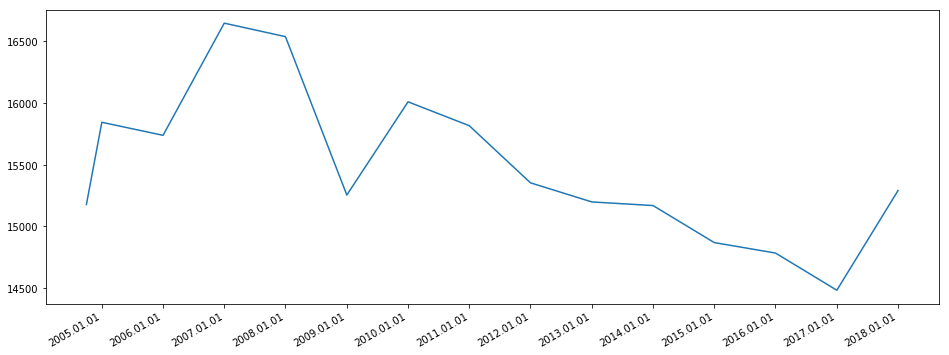

In [3]:
df = load_df()
years = split(df)
dates = [year.iloc[0, 0] for year in years]
means = [year.iloc[:, 1].mean() for year in years]
plot_x_as_date(lambda fig, ax: sb.lineplot(x=dates, y=means, ax=ax), x_major_locator='year')

### Overlapped monthly means for every years

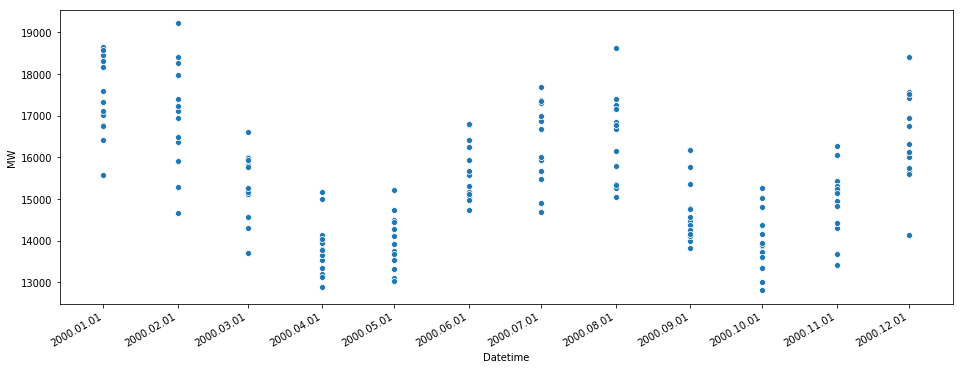

In [4]:
overlapped_years = pd.DataFrame(columns=df.columns)
for year in years:
    months = split(year, mode='month')

    for month in months:
        overlapped_years = overlapped_years.append({df.columns[0]: month.iloc[0, 0], df.columns[1]: month.iloc[:, 1].mean()}, ignore_index=True)

overlapped_years.loc[:, 'Datetime'] = overlapped_years.loc[:, 'Datetime'].map(lambda datetime: datetime.replace(year=2000))
overlapped_years = overlapped_years.sort_values(by='Datetime', ascending=True)

def plot_body(fig, ax):
    ax.set_xlim([datetime.date(2000, 1, 1), datetime.date(2000, 12, 31)])
    sb.scatterplot(x=overlapped_years.iloc[:, 0], y=overlapped_years.iloc[:, 1], ax=ax)
plot_x_as_date(plot_body, x_major_locator='month')

### Monthly means for every years

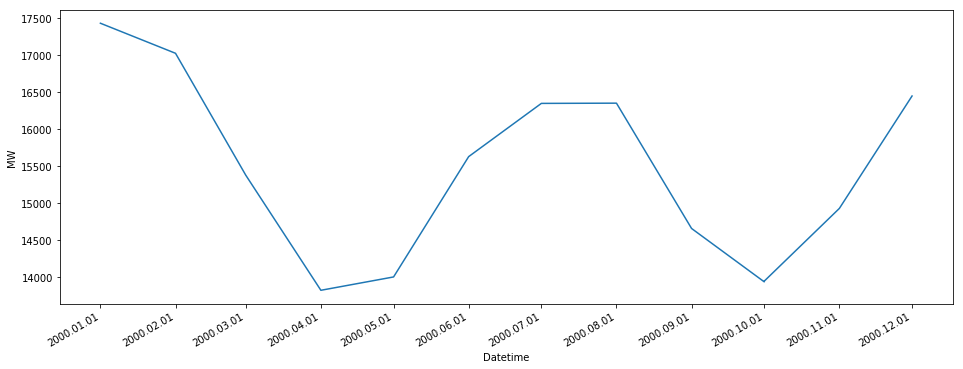

In [5]:
consumptions_per_year = {}
for row in range(len(overlapped_years)):
    key = overlapped_years.iloc[row, 0]
    value = overlapped_years.iloc[row, 1]
    if key in consumptions_per_year:
        consumptions_per_year[key].append(value)
    else:
        consumptions_per_year[key] = [value]

monthly_mean = pd.DataFrame(columns=df.columns)
for key in consumptions_per_year:
    monthly_mean = monthly_mean.append({df.columns[0]: key, df.columns[1]: np.mean(consumptions_per_year[key])}, ignore_index=True)

monthly_mean = monthly_mean.sort_values(by='Datetime', ascending=True)

def plot_body(fig, ax):
    ax.set_xlim([datetime.date(2000, 1, 1), datetime.date(2000, 12, 31)])
    sb.lineplot(x=monthly_mean.iloc[:, 0], y=monthly_mean.iloc[:, 1], ax=ax)
plot_x_as_date(plot_body, x_major_locator='month')

# Fitting curve with Tensorflow

In [6]:
import tensorflow as tf

def dense(x, unit, act=tf.nn.relu):
    initializer = tf.contrib.layers.xavier_initializer()
    
    return tf.layers.dense(x, unit, activation=act)

def build_network(normalize_info, mode=0, poly_dim=6):
    x, y = tf.placeholder(np.float64, (None, 1)), tf.placeholder(np.float64, (None, 1))
    min_x, max_x, min_y, max_y = normalize_info
    
    norm_x = normalize(x, max_x, min_x, 1, -1)
    norm_y = normalize(y, max_y, min_y, 1, -1)
    
    if mode == 0:
        norm_out = norm_x
        norm_out = dense(norm_out, 500)
        norm_out = dense(norm_out, 200)
        norm_out = dense(norm_out, 100)
        norm_out = dense(norm_out, 45)
        norm_out = dense(norm_out, 1, act=None)
    elif mode == 1:
        norm_outs = []
        for degree in range(poly_dim, 0, -1):
            norm_outs.append(dense(tf.pow(norm_x, degree), 1, act=None))
        norm_out = tf.reduce_sum(norm_outs, axis=0)
    elif mode == 2:
        norm_outs = []
        for degree in range(poly_dim, 0, -1):
            coef = tf.Variable(0, dtype=tf.float64)
            norm_outs.append(coef * tf.pow(norm_x, degree))
        norm_out = tf.reduce_sum(norm_outs, axis=0)
    
    loss = tf.losses.mean_squared_error(norm_y, norm_out)
    minimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss)
    
    out = denormalize(norm_out, max_y, min_y, 1, -1)

    return x, y, out, loss, minimizer

def create_dataset(df, train_ratio):
    def preprocess(data):
        x = data.iloc[:, 0].values.reshape((-1, 1))
        y = data.iloc[:, 1].values.reshape((-1, 1))
        x = timestamp_series_to_millisecs(x)
        
        return x, y
    
    data_count = len(df)
    train_count = int(data_count * train_ratio)

    train_indices = np.random.choice(data_count, size=train_count, replace=False)
    train_mask = np.full(data_count, False)
    train_mask[train_indices] = True

    test_mask = np.full(data_count, True)
    test_mask[train_indices] = False
    
    ts = timestamp_series_to_millisecs(df.iloc[:, 0])
    watts = df.iloc[:, 1]
    normalize_info = ts.min(), ts.max(), watts.min(), watts.max()
    
    train_set = df.iloc[train_mask]
    test_set = df.iloc[test_mask]
    
    train_x, train_y = preprocess(train_set)
    test_x, test_y = preprocess(test_set)
    
    return train_x, train_y, test_x, test_y, normalize_info

def create_dummy_dataset():
    def f(x):
#         return 1e-4 * (3*x**5 + 7*x**4 + 4*x**3 + x**2 + x)
        return (x - 10) * (x + 10) * (x - 5) * (x + 5) * (x - 7) * (x + 7)
    
    x_train = 20 * np.random.rand(9000) - 10
    y_train = f(x_train)

    x_test = np.linspace(-10, 10, num=100)
    y_test = f(x_test)
    
    x_train = x_train.reshape((-1, 1))
    y_train = y_train.reshape((-1, 1))
    x_test = x_test.reshape((-1, 1))
    y_test = y_test.reshape((-1, 1))
    
    xs = np.concatenate([x_train, x_test])
    ys = np.concatenate([y_train, y_test])
    normalize_info = xs.min(), xs.max(), ys.min(), ys.max()
    
    return x_train, y_train, x_test, y_test, normalize_info

def create_batch(x, y, size):
    mask = np.random.choice(len(x), size=size, replace=False)
    
    return x[mask], y[mask]

def normalize_batches(batch_x, batch_y):
    x_ptp = batch_x.ptp()
    y_ptp = batch_y.ptp()
    batch_x = normalize(batch_x, batch_x.min(), batch_x.max(), 0, (x_ptp // 10))
    batch_y = normalize(batch_y, batch_y.min(), batch_y.max(), 0, (y_ptp // 10))
    
    return batch_x, batch_y

def normalize(t, high, low, norm_high, norm_low):
    t = (t - low) / (high - low)
    t = t * (norm_high - norm_low) + norm_low

    return t

def denormalize(t, high, low, norm_high, norm_low):
    return normalize(t, norm_high, norm_low, high, low)

### Fit over small amount of dataset

Reading data/AEP_hourly.csv


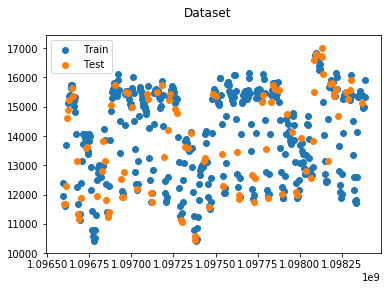

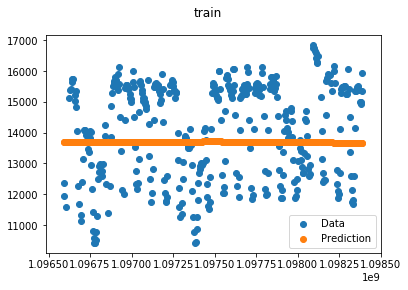

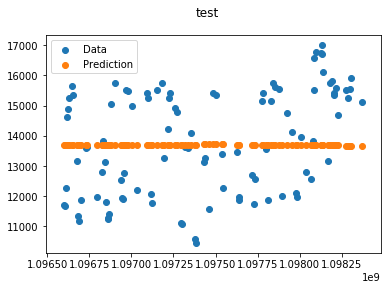

Loss(0): 0.2497183233499527


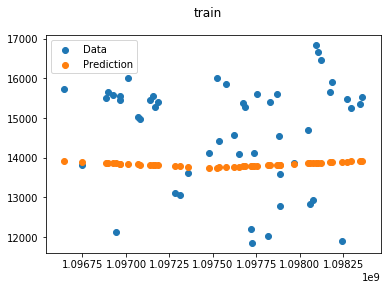

Loss(100): 0.19487033784389496
Loss(200): 0.17239847779273987
Loss(300): 0.1329142451286316
Loss(400): 0.15076223015785217
Loss(500): 0.16463544964790344
Loss(600): 0.17203383147716522
Loss(700): 0.1209031492471695
Loss(800): 0.21264193952083588
Loss(900): 0.14005154371261597
Loss(1000): 0.14278729259967804


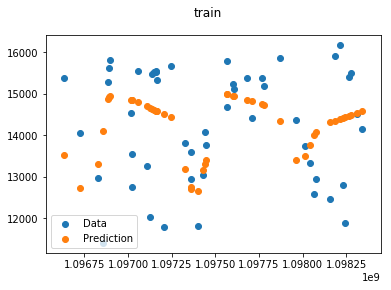

Loss(1100): 0.18412630259990692
Loss(1200): 0.13236510753631592
Loss(1300): 0.17026004195213318
Loss(1400): 0.17310161888599396
Loss(1500): 0.133070170879364
Loss(1600): 0.16959001123905182
Loss(1700): 0.15450496971607208
Loss(1800): 0.17528671026229858
Loss(1900): 0.1731145828962326
Loss(2000): 0.12093758583068848


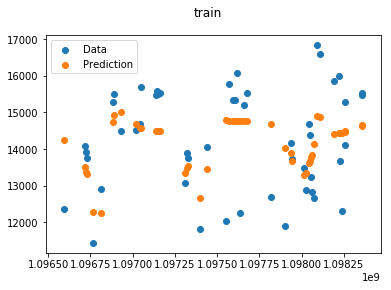

Loss(2100): 0.1433577686548233
Loss(2200): 0.1780269742012024
Loss(2300): 0.14043086767196655
Loss(2400): 0.15690097212791443
Loss(2500): 0.13056783378124237
Loss(2600): 0.15261098742485046
Loss(2700): 0.17172618210315704
Loss(2800): 0.1438625007867813
Loss(2900): 0.12915122509002686
Loss(3000): 0.12767253816127777


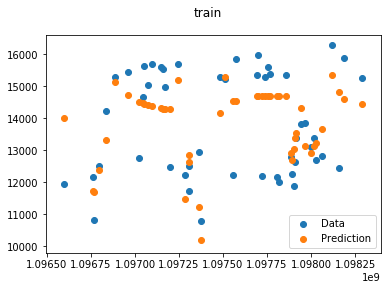

Loss(3100): 0.15055222809314728
Loss(3200): 0.1309487223625183
Loss(3300): 0.12417344748973846
Loss(3400): 0.11106140911579132
Loss(3500): 0.14786596596240997
Loss(3600): 0.15775556862354279
Loss(3700): 0.10732300579547882
Loss(3800): 0.1333112269639969
Loss(3900): 0.11133895069360733
Loss(4000): 0.11316876113414764


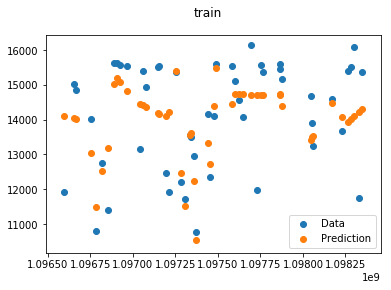

Loss(4100): 0.08883108198642731
Loss(4200): 0.09497334808111191
Loss(4300): 0.16575385630130768
Loss(4400): 0.09351059049367905
Loss(4500): 0.1686692088842392
Loss(4600): 0.13856783509254456
Loss(4700): 0.1055748462677002
Loss(4800): 0.0895448848605156
Loss(4900): 0.0907619446516037
Loss(5000): 0.11238513141870499


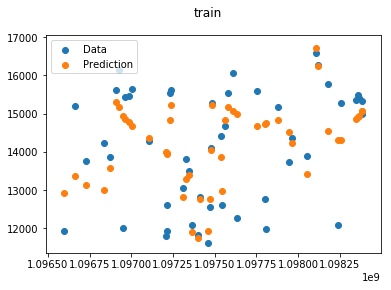

Loss(5100): 0.11518336087465286
Loss(5200): 0.09649062901735306
Loss(5300): 0.11221950501203537
Loss(5400): 0.0926731750369072
Loss(5500): 0.12726201117038727
Loss(5600): 0.07807689905166626
Loss(5700): 0.11422453820705414
Loss(5800): 0.1198943555355072
Loss(5900): 0.12137694656848907
Loss(6000): 0.11076515913009644


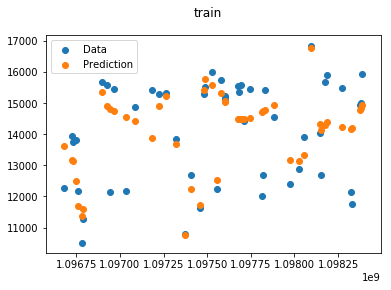

Loss(6100): 0.08349763602018356
Loss(6200): 0.09551968425512314
Loss(6300): 0.11019662022590637
Loss(6400): 0.09580074995756149
Loss(6500): 0.11447378993034363
Loss(6600): 0.08048425614833832
Loss(6700): 0.12117981910705566
Loss(6800): 0.07156619429588318
Loss(6900): 0.08633866906166077
Loss(7000): 0.07616662234067917


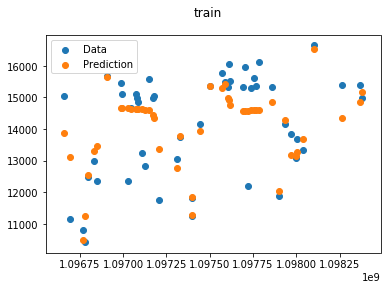

Loss(7100): 0.10914326459169388
Loss(7200): 0.06384860724210739
Loss(7300): 0.08356893807649612
Loss(7400): 0.09309131652116776
Loss(7500): 0.0910249799489975
Loss(7600): 0.10072033852338791
Loss(7700): 0.1029534637928009
Loss(7800): 0.09021156281232834
Loss(7900): 0.09052179008722305
Loss(8000): 0.06892497837543488


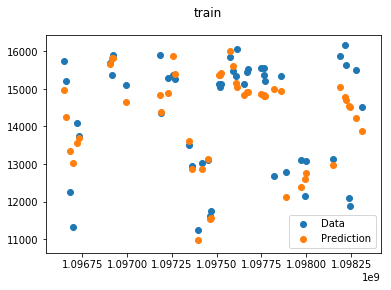

Loss(8100): 0.09249356389045715
Loss(8200): 0.06425750255584717
Loss(8300): 0.09662065654993057
Loss(8400): 0.10487017780542374
Loss(8500): 0.08767527341842651
Loss(8600): 0.07287488877773285
Loss(8700): 0.09086812287569046
Loss(8800): 0.15276461839675903
Loss(8900): 0.07296392321586609
Loss(9000): 0.09550449997186661


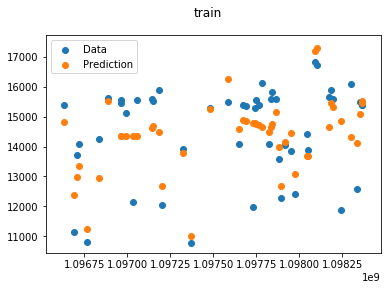

Loss(9100): 0.08748183399438858
Loss(9200): 0.1211889237165451
Loss(9300): 0.06374899297952652
Loss(9400): 0.07819101214408875
Loss(9500): 0.06958180665969849
Loss(9600): 0.08056129515171051
Loss(9700): 0.07621252536773682
Loss(9800): 0.08541315048933029
Loss(9900): 0.03660931810736656


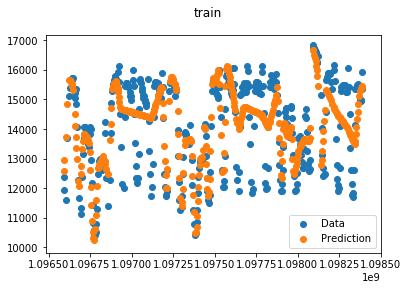

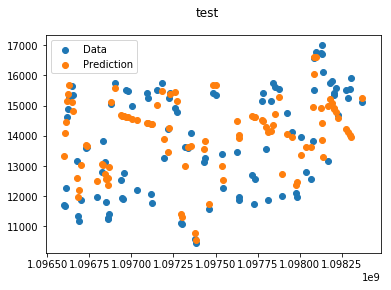

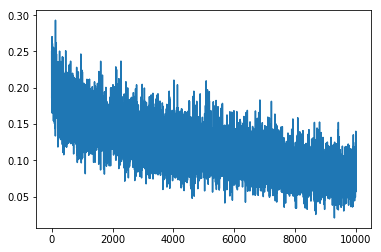

In [7]:
def train(train_x, train_y, test_x, test_y, normalize_info, steps=10000, mode=0, poly_dim=5):
    plt.scatter(train_x, train_y, label='Train')
    plt.scatter(test_x, test_y, label='Test')
    plt.suptitle('Dataset')
    plt.legend()
    plt.show()

    loss_history = []

    tf.reset_default_graph()
    with tf.Session() as sess:
        x, y, out, loss, minimizer = build_network(normalize_info, mode=mode, poly_dim=poly_dim)

        def predict(sess, x_batch, y_batch, title):
            test_out = sess.run(out, feed_dict={x: x_batch})

            plt.scatter(x_batch, y_batch, label='Data')
            plt.scatter(x_batch, test_out, label='Prediction')
            plt.suptitle(title)
            plt.legend()
            plt.show()

        sess.run(tf.global_variables_initializer())

        predict(sess, train_x, train_y, 'train')
        predict(sess, test_x, test_y, 'test')
        for i in range(steps):
            batch_x, batch_y = create_batch(train_x, train_y, 50)

            loss_res, _ = sess.run([loss, minimizer], feed_dict={x: batch_x, y: batch_y})
            loss_history.append(loss_res)

            if i % 100 == 0:
                print(f"Loss({i}): {loss_res}")
            if i % 1000 == 0:
                predict(sess, batch_x, batch_y, 'train')

        predict(sess, train_x, train_y, 'train')
        predict(sess, test_x, test_y, 'test')
        plt.plot(loss_history)
        plt.show()

# TODO: This dataset may not suit for regression problem. See what "overfit" means on curve fitting.
df = load_df()
train_x, train_y, test_x, test_y, normalize_info = create_dataset(df.iloc[:500], 0.8)
# train_x, train_y, test_x, test_y, normalize_info = create_dummy_dataset()

train(train_x, train_y, test_x, test_y, normalize_info)

### Fit over small amount of dataset using Keras

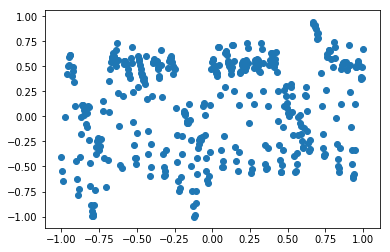

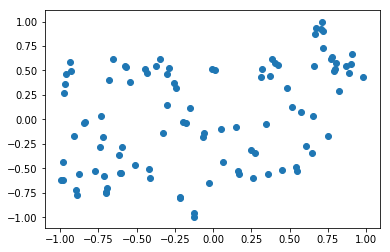

Epoch 1/200
400/400 [==============================] - 1s 1ms/step - loss: 0.2227
Epoch 2/200
400/400 [==============================] - 0s 66us/step - loss: 0.2156
Epoch 3/200
400/400 [==============================] - 0s 67us/step - loss: 0.2131
Epoch 4/200
400/400 [==============================] - 0s 66us/step - loss: 0.2123
Epoch 5/200
400/400 [==============================] - 0s 66us/step - loss: 0.2086
Epoch 6/200
400/400 [==============================] - 0s 69us/step - loss: 0.2081
Epoch 7/200
400/400 [==============================] - 0s 68us/step - loss: 0.2086
Epoch 8/200
400/400 [==============================] - 0s 66us/step - loss: 0.2063
Epoch 9/200
400/400 [==============================] - 0s 66us/step - loss: 0.2035
Epoch 10/200
400/400 [==============================] - 0s 64us/step - loss: 0.2016
Epoch 11/200
400/400 [==============================] - 0s 67us/step - loss: 0.1997
Epoch 12/200
400/400 [==============================] - 0s 65us/step - loss: 0.1996
Ep

400/400 [==============================] - 0s 67us/step - loss: 0.1611
Epoch 99/200
400/400 [==============================] - 0s 68us/step - loss: 0.1612
Epoch 100/200
400/400 [==============================] - 0s 65us/step - loss: 0.1666
Epoch 101/200
400/400 [==============================] - 0s 65us/step - loss: 0.1657
Epoch 102/200
400/400 [==============================] - 0s 70us/step - loss: 0.1656
Epoch 103/200
400/400 [==============================] - 0s 74us/step - loss: 0.1692
Epoch 104/200
400/400 [==============================] - 0s 101us/step - loss: 0.1642
Epoch 105/200
400/400 [==============================] - 0s 105us/step - loss: 0.1650
Epoch 106/200
400/400 [==============================] - 0s 104us/step - loss: 0.1642
Epoch 107/200
400/400 [==============================] - 0s 96us/step - loss: 0.1584
Epoch 108/200
400/400 [==============================] - 0s 94us/step - loss: 0.1604
Epoch 109/200
400/400 [==============================] - 0s 85us/step - loss:

400/400 [==============================] - 0s 71us/step - loss: 0.1481
Epoch 195/200
400/400 [==============================] - 0s 65us/step - loss: 0.1495
Epoch 196/200
400/400 [==============================] - 0s 70us/step - loss: 0.1452
Epoch 197/200
400/400 [==============================] - 0s 81us/step - loss: 0.1450
Epoch 198/200
400/400 [==============================] - 0s 97us/step - loss: 0.1529
Epoch 199/200
400/400 [==============================] - 0s 89us/step - loss: 0.1553
Epoch 200/200
100/100 [==============================] - 0s 862us/step


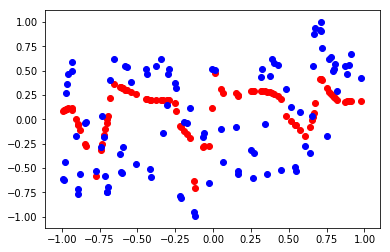

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

x_train, y_train, x_test, y_test, _ = create_dataset(df.iloc[:500], 0.8)
# x_train, y_train, x_test, y_test, _ = create_dummy_dataset()

def train_with_keras(x_train, y_train, x_test, y_test):
    xs, ys = np.concatenate([x_train, x_test]), np.concatenate([y_train, y_test])
    x_train = normalize(x_train, xs.max(), xs.min(), 1, -1)
    x_test = normalize(x_test, xs.max(), xs.min(), 1, -1)
    y_train = normalize(y_train, ys.max(), ys.min(), 1, -1)
    y_test = normalize(y_test, ys.max(), ys.min(), 1, -1)

    plt.scatter(x_train, y_train)
    plt.show()
    plt.scatter(x_test, y_test)
    plt.show()

    model = Sequential()
    model.add(Dense(units=500, input_dim=1))
    model.add(Activation('relu'))
    model.add(Dense(units=200, input_dim=1))
    model.add(Activation('relu'))
    model.add(Dense(units=100, input_dim=1))
    model.add(Activation('relu'))
    model.add(Dense(units=45))
    model.add(Activation('relu'))
    model.add(Dense(units=1))

    model.compile(loss='mean_squared_error',
                  optimizer='adam')

    model.fit(x_train, y_train, epochs=200, batch_size=50, verbose=1)

    loss_and_metrics = model.evaluate(x_test, y_test, batch_size=100)

    classes = model.predict(x_test, batch_size=1)

    test=x_test.reshape(-1)
    plt.scatter(test, classes, c='r')
    plt.scatter(test, y_test, c='b')
    plt.show()

train_with_keras(train_x, train_y, test_x, test_y)

### Train over monthly mean for every year

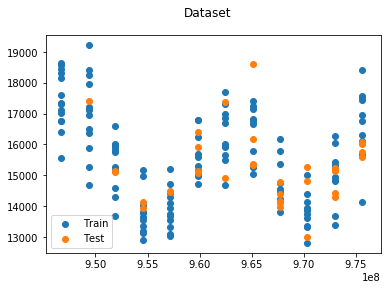

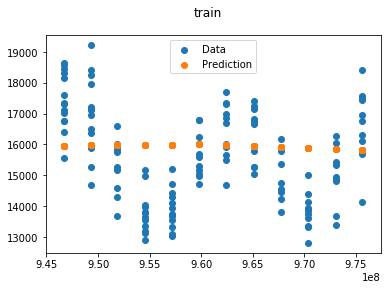

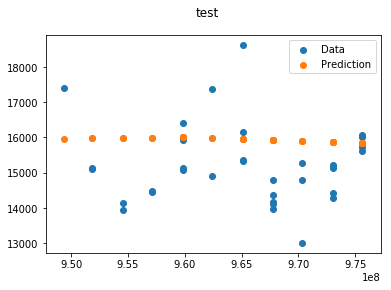

Loss(0): 0.27669140696525574


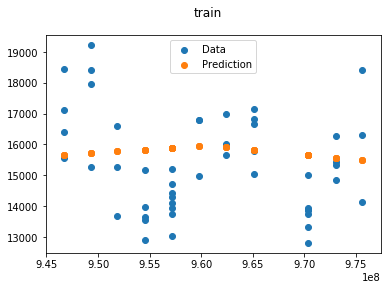

Loss(100): 0.07907246798276901
Loss(200): 0.0552801713347435
Loss(300): 0.07578040659427643
Loss(400): 0.10358241200447083
Loss(500): 0.08243117481470108
Loss(600): 0.10036005079746246
Loss(700): 0.08132722228765488
Loss(800): 0.08097867667675018
Loss(900): 0.08528614789247513
Loss(1000): 0.08649366348981857


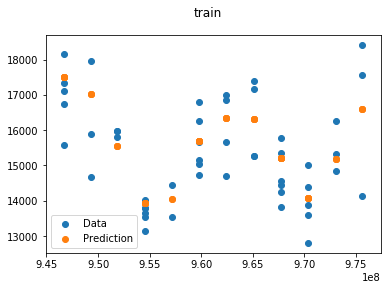

Loss(1100): 0.07876843214035034
Loss(1200): 0.07278075814247131
Loss(1300): 0.06410479545593262
Loss(1400): 0.0659201517701149
Loss(1500): 0.07878120243549347
Loss(1600): 0.0571565255522728
Loss(1700): 0.06449301540851593
Loss(1800): 0.05244602635502815
Loss(1900): 0.06619317084550858
Loss(2000): 0.08420798182487488


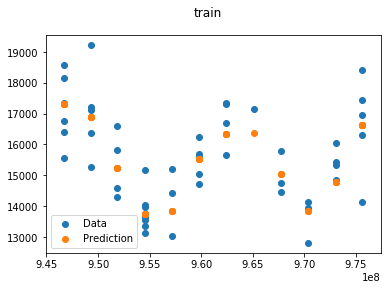

Loss(2100): 0.06735358387231827
Loss(2200): 0.07242149859666824
Loss(2300): 0.07044503837823868
Loss(2400): 0.07095876336097717
Loss(2500): 0.06457607448101044
Loss(2600): 0.08349080383777618
Loss(2700): 0.04664672911167145
Loss(2800): 0.07153253257274628
Loss(2900): 0.08213185518980026
Loss(3000): 0.09317932277917862


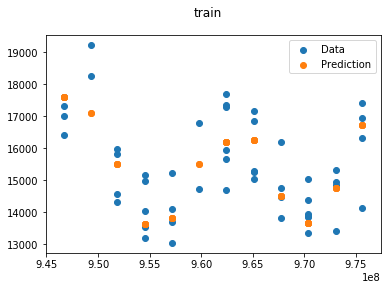

Loss(3100): 0.05924904718995094
Loss(3200): 0.06462840735912323
Loss(3300): 0.05360524356365204
Loss(3400): 0.09028498828411102
Loss(3500): 0.09064269810914993
Loss(3600): 0.06004286929965019
Loss(3700): 0.06598900258541107
Loss(3800): 0.06488949060440063
Loss(3900): 0.05798746272921562
Loss(4000): 0.05448654666543007


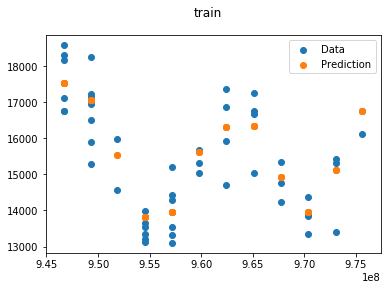

Loss(4100): 0.08254153281450272
Loss(4200): 0.06168101355433464
Loss(4300): 0.08655407279729843
Loss(4400): 0.09052767604589462
Loss(4500): 0.0784074068069458
Loss(4600): 0.05814564600586891
Loss(4700): 0.0702342540025711
Loss(4800): 0.08038017898797989
Loss(4900): 0.09886371344327927


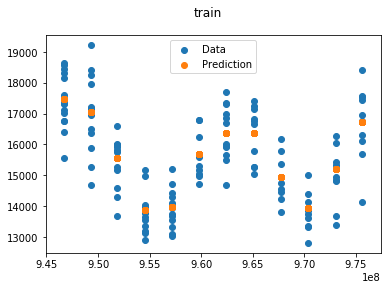

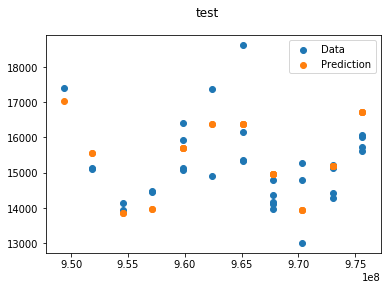

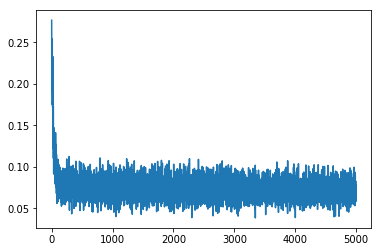

In [9]:
train_x, train_y, test_x, test_y, normalize_info = create_dataset(overlapped_years, 0.8)
train(train_x, train_y, test_x, test_y, normalize_info, steps=5000)

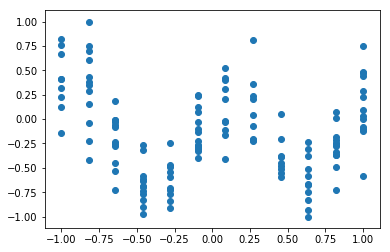

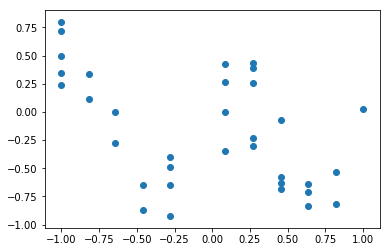

Epoch 1/200
133/133 [==============================] - 0s 2ms/step - loss: 0.3317
Epoch 2/200
133/133 [==============================] - 0s 90us/step - loss: 0.1910
Epoch 3/200
133/133 [==============================] - 0s 89us/step - loss: 0.1113
Epoch 4/200
133/133 [==============================] - 0s 85us/step - loss: 0.0937
Epoch 5/200
133/133 [==============================] - 0s 86us/step - loss: 0.0873
Epoch 6/200
133/133 [==============================] - 0s 85us/step - loss: 0.0873
Epoch 7/200
133/133 [==============================] - 0s 86us/step - loss: 0.0824
Epoch 8/200
133/133 [==============================] - 0s 87us/step - loss: 0.0750
Epoch 9/200
133/133 [==============================] - 0s 87us/step - loss: 0.0729
Epoch 10/200
133/133 [==============================] - 0s 83us/step - loss: 0.0752
Epoch 11/200
133/133 [==============================] - 0s 89us/step - loss: 0.0754
Epoch 12/200
133/133 [==============================] - 0s 89us/step - loss: 0.0747
Ep

133/133 [==============================] - 0s 86us/step - loss: 0.0725
Epoch 99/200
133/133 [==============================] - 0s 88us/step - loss: 0.0725
Epoch 100/200
133/133 [==============================] - 0s 87us/step - loss: 0.0730
Epoch 101/200
133/133 [==============================] - 0s 86us/step - loss: 0.0724
Epoch 102/200
133/133 [==============================] - 0s 88us/step - loss: 0.0736
Epoch 103/200
133/133 [==============================] - 0s 89us/step - loss: 0.0727
Epoch 104/200
133/133 [==============================] - 0s 87us/step - loss: 0.0721
Epoch 105/200
133/133 [==============================] - 0s 93us/step - loss: 0.0733
Epoch 106/200
133/133 [==============================] - 0s 88us/step - loss: 0.0735
Epoch 107/200
133/133 [==============================] - 0s 84us/step - loss: 0.0724
Epoch 108/200
133/133 [==============================] - 0s 82us/step - loss: 0.0724
Epoch 109/200
133/133 [==============================] - 0s 87us/step - loss: 0.

133/133 [==============================] - 0s 98us/step - loss: 0.0725
Epoch 195/200
133/133 [==============================] - 0s 97us/step - loss: 0.0727
Epoch 196/200
133/133 [==============================] - 0s 94us/step - loss: 0.0727
Epoch 197/200
133/133 [==============================] - 0s 97us/step - loss: 0.0725
Epoch 198/200
133/133 [==============================] - 0s 99us/step - loss: 0.0724
Epoch 199/200
133/133 [==============================] - 0s 79us/step - loss: 0.0726
Epoch 200/200
34/34 [==============================] - 0s 2ms/step


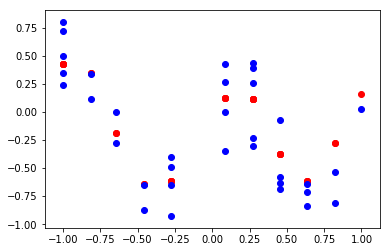

In [10]:
train_x, train_y, test_x, test_y, normalize_info = create_dataset(overlapped_years, 0.8)
train_with_keras(train_x, train_y, test_x, test_y)

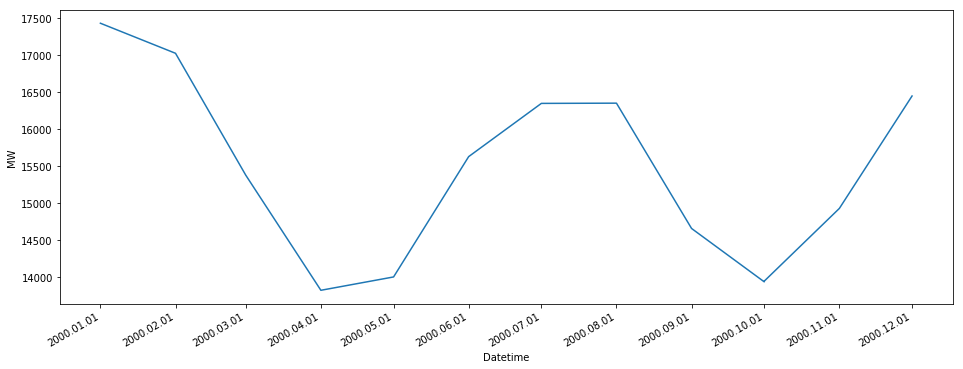

In [11]:
def plot_body(fig, ax):
    ax.set_xlim([datetime.date(2000, 1, 1), datetime.date(2000, 12, 31)])
    sb.lineplot(x=monthly_mean.iloc[:, 0], y=monthly_mean.iloc[:, 1], ax=ax)
plot_x_as_date(plot_body, x_major_locator='month')